In [1]:
import mrsqm
import numpy as np
import pandas as pd
from sklearn import metrics
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
# code to read arff data
# Source: https://github.com/alan-turing-institute/sktime/blob/main/sktime/utils/data_io.py

def load_from_arff_to_dataframe(

    full_file_path_and_name,
    has_class_labels=True,
    return_separate_X_and_y=True,
    replace_missing_vals_with="NaN",
):
    """Load data from a .ts file into a Pandas DataFrame.
    Parameters
    ----------
    full_file_path_and_name: str
        The full pathname of the .ts file to read.
    has_class_labels: bool
        true then line contains separated strings and class value contains
        list of separated strings, check for 'return_separate_X_and_y'
        false otherwise.
    return_separate_X_and_y: bool
        true then X and Y values should be returned as separate Data Frames (
        X) and a numpy array (y), false otherwise.
        This is only relevant for data.
    replace_missing_vals_with: str
       The value that missing values in the text file should be replaced
       with prior to parsing.
    Returns
    -------
    DataFrame, ndarray
        If return_separate_X_and_y then a tuple containing a DataFrame and a
        numpy array containing the relevant time-series and corresponding
        class values.
    DataFrame
        If not return_separate_X_and_y then a single DataFrame containing
        all time-series and (if relevant) a column "class_vals" the
        associated class values.
    """
    
    instance_list = []
    class_val_list = []

    data_started = False
    is_multi_variate = False
    is_first_case = True

    # Parse the file
    # print(full_file_path_and_name)
    with open(full_file_path_and_name, "r", encoding="utf-8") as f:
        for line in f:

            if line.strip():
                if (
                    is_multi_variate is False
                    and "@attribute" in line.lower()
                    and "relational" in line.lower()
                ):
                    is_multi_variate = True

                if "@data" in line.lower():
                    data_started = True
                    continue

                # if the 'data tag has been found, the header information
                # has been cleared and now data can be loaded
                if data_started:
                    line = line.replace("?", replace_missing_vals_with)

                    if is_multi_variate:
                        if has_class_labels:
                            line, class_val = line.split("',")
                            class_val_list.append(class_val.strip())
                        dimensions = line.split("\\n")
                        dimensions[0] = dimensions[0].replace("'", "")

                        if is_first_case:
                            for _d in range(len(dimensions)):
                                instance_list.append([])
                            is_first_case = False

                        for dim in range(len(dimensions)):
                            instance_list[dim].append(
                                pd.Series(
                                    [float(i) for i in dimensions[dim].split(",")]
                                )
                            )

                    else:
                        if is_first_case:
                            instance_list.append([])
                            is_first_case = False

                        line_parts = line.split(",")
                        if has_class_labels:
                            instance_list[0].append(
                                pd.Series(
                                    [
                                        float(i)
                                        for i in line_parts[: len(line_parts) - 1]
                                    ]
                                )
                            )
                            class_val_list.append(line_parts[-1].strip())
                        else:
                            instance_list[0].append(
                                pd.Series(
                                    [float(i) for i in line_parts[: len(line_parts)]]
                                )
                            )

    x_data = pd.DataFrame(dtype=np.float32)
    for dim in range(len(instance_list)):
        x_data["dim_" + str(dim)] = instance_list[dim]

    if has_class_labels:
        if return_separate_X_and_y:
            return x_data, np.asarray(class_val_list)
        else:
            x_data["class_vals"] = pd.Series(class_val_list)

    return x_data

# code to visualize saliency map
# Source: https://github.com/mlgig/explanation4tsc/blob/master/3.%20Compare%20Metrics%20and%20Draw%20Figures.ipynb
def plot_time_series_with_color(ts, weight, save = False):   
    cas = weight
    
    def transform(X):
        ma,mi = np.max(X), np.min(X)
        X = (X - mi)/(ma-mi)
        return X*100
    cas = transform(cas)

    max_length1, max_length2 = len(weight),10000 #
    x1 = np.linspace(0,max_length1,num = max_length1)
    x2 = np.linspace(0,max_length1,num = max_length2)
    y1 = ts
    f = interp1d(x1, y1)

    fcas = interp1d(x1, cas)
    cas = fcas(x2)

    plt.figure(figsize = (5,3.5))
    
    plt.scatter(x2,f(x2), c = cas, cmap = 'jet', marker='.', s= 1,vmin=0,vmax = 100)    
    if save: plt.savefig('imgout/SM_%s_%s_Class%d_idx%d.png' %(dataset, explanation_method, label[i],i))


## Load dataset

In [3]:
X_train,y_train = load_from_arff_to_dataframe("data/Coffee/Coffee_TRAIN.arff")
X_test,y_test = load_from_arff_to_dataframe("data/Coffee/Coffee_TEST.arff")

## Train with MrSQMClassifier

In [25]:
clf = mrsqm.MrSQMClassifier().fit(X_train,y_train)

## Test the model

In [26]:
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9642857142857143


## Saliency map visualisation

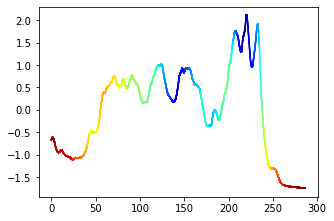

In [29]:
ts = X_train.iloc[24,0]
weight = clf.get_saliency_map(ts)
plot_time_series_with_color(ts, weight[1])

## Control SAX and SFA transformation

In [32]:
# use sfa twice more times than sax
clf = mrsqm.MrSQMClassifier(nsax=2, nsfa=4).fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9642857142857143
